# Wildfires: MODIS

## Context
### Purpose
Explore [MODIS](https://cmr.earthdata.nasa.gov/search/concepts/C1378227407-LAADS.html) satellite imagery and wildfire data that is open and free for scientific use.

### Sensor description
The [MOD021KM](https://cmr.earthdata.nasa.gov/search/concepts/C1378227407-LAADS.html) product contains calibrated and geolocated at-aperture radiances for 36 discrete bands located in the 0.4 to 14.4 micron region of the electromagnetic spectrum.


### Highlights
* Use `satpy` to load, visualise, and regrid MODIS level 1B data.
* Fetch a fire database containing some 497364 fires from 2020.
* Visualisation of fire pixels from the database.
* Visualisation of the fire pixels alongside bands from the MODIS satellite data.

### Authors
Samuel Jackson, Science & Technology Facilities Council, [@samueljackson92](https://github.com/samueljackson92)

### Reviewers
Alejandro Coca-Castro, The Alan Turing Institute, [@acocac](https://github.com/acocac), 06/09/21 (latest revision)

:::{note}
The author acknowledges [MODIS Science Team](https://doi.org/10.5067/modis/mod021km.061) and the use of data and/or imagery from NASA's Fire Information for Resource Management System (FIRMS) (https://earthdata.nasa.gov/firms), part of NASA's Earth Observing System Data and Information System (EOSDIS).
:::

## Install and load libraries

In [1]:
! pip -q install pyspectral
! pip -q install 'satpy[modis_l1b]==0.26.0'

In [7]:
import pandas as pd
import numpy as np
import geopandas
import intake
import fsspec, aiohttp
import hvplot.xarray
import hvplot.pandas
import holoviews as hv
import panel as pn
import satpy
import xarray as xr
import tempfile
from pathlib import Path
from scipy.spatial import cKDTree
from satpy.writers import get_enhanced_image
from getpass import getpass
from pathlib import Path
from pyresample import geometry
import datetime
import urllib.request
import os.path

## Fetch Data


:::{note}
To download data from the [NASA's Earth Data site](https://urs.earthdata.nasa.gov/) you must have a valid Earth Data account. Please register with Earth Data is you do not already have an account and then provide your username and password when prompted in the cell below.
:::

:::{important}
In order to download MODIS level1 data you must have authorized access to `LAADS Web` on your account. To do this navigate to your earthdata profile page

 - Click "Applications"
 - Click "Authorized Apps"
 - Click "Autorize More Applications"
 - Search for "LAADS Web"
 - Click "Authorize"
 
Now you should successfully be able to download MODIS data.
:::

In [14]:
fname = 'MOD021KM.A2020245.0840.061.2020245193036.hdf'

if not os.path.isfile(fname) or os.path.getsize(fname) == 0:
    username = input('Username: ')
    password = getpass('Password: ')

    fsspec.config.conf['https'] = dict(client_kwargs={'auth': aiohttp.BasicAuth(username, password)})

    url = f'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2020/245/{fname}'
    filename = url.split('/')[-1]
    with fsspec.open(url) as f:
        with Path(filename).open('wb') as handle:
            data = f.read()
            try:
                data.decode('utf-8')
                raise RuntimeError('Could not download MODIS data! Have you authorized LAADS Web in your Eathdata account above?')
            except UnicodeDecodeError:
                handle.write(data)

Download the database of MODIS wildfires from a publically accessible location.

In [8]:
filepath = 'https://firms2.modaps.eosdis.nasa.gov/data/country/zips/'
filename = 'modis_2020_all_countries.zip'

if not os.path.isfile(filename) or os.path.getsize(filename) == 0:
    urllib.request.urlretrieve(filepath+filename, '../sensors/' + filename)
    !unzip modis_2020_all_countries.zip

('../sensors/modis_2020_all_countries.zip',
 <http.client.HTTPMessage at 0x7f88d36929d0>)

Load an intake catalog for the downloaded data

In [9]:
path = Path(tempfile.mkdtemp())
catalog_file = path / 'catalog.yaml'

with catalog_file.open('w') as f:
    f.write('''
sources:
    modis_l1b:
      args:
        urlpath: 'MOD021KM.A2020245.0840.061.2020245193036.hdf'
        reader: 'modis_l1b'
      description: "MODIS Level 1B Products"
      driver: SatpySource
      metadata: {}
    modis_fires:
      args:
        urlpath: 'modis/2020/modis_*.csv'
      description: "MODIS Level 2 Fires"
      driver: csv
      metadata: {}
''')

In [10]:
from intake.source.base import PatternMixin
from intake.source.base import DataSource, Schema

import glob

class SatpySource(DataSource, PatternMixin):
    """Intake driver for data supported by satpy.Scene"""
    
    container = 'python'
    name = 'satpy'
    version = '0.0.1'
    partition_access = False

    def __init__(self, urlpath, reader=None, metadata=None, path_as_pattern=True):
        """
        Parameters
        ----------
        path: str, location of model pkl file
        Either the absolute or relative path to the file
        opened. Some examples:
          - ``{{ CATALOG_DIR }}/file.nat``
          - ``{{ CATALOG_DIR }}/*.nc``
        reader: str, optional
        Name of the satpy reader to use when loading data (ie. ``modis_l1b``)
        metadata: dict, optional
        Additional metadata to pass to the intake catalog
        path_as_pattern: bool or str, optional
        Whether to treat the path as a pattern (ie. ``data_{field}.nc``)
        and create new coodinates in the output corresponding to pattern
        fields. If str, is treated as pattern to match on. Default is True.
        """

        self.path_as_pattern = path_as_pattern
        self.urlpath = urlpath
        self._reader = reader
        super(SatpySource, self).__init__(metadata=metadata)

    def _load(self):
        files = self.urlpath
        files = list(glob.glob(files))
        return satpy.Scene(files, reader=self._reader)
    
    def _get_schema(self):
        self._schema = Schema(
            npartitions=1,
            extra_metadata={}
        )
        return self._schema

    def read(self):
        self._load_metadata()
        return self._load()

intake.register_driver('SatpySource', SatpySource, overwrite=True)
cat = intake.open_catalog(catalog_file)

## Load MODIS Satellite Data

Here we use `satpy` to load the MODIS level 1b data into memory. As well as loading the image data, `satpy` provides a easy way to regrid the data to different coordinate systems.

In [15]:
scn = cat['modis_l1b'].read()
scn

/Users/acoca/anaconda3/envs/envai-book/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))


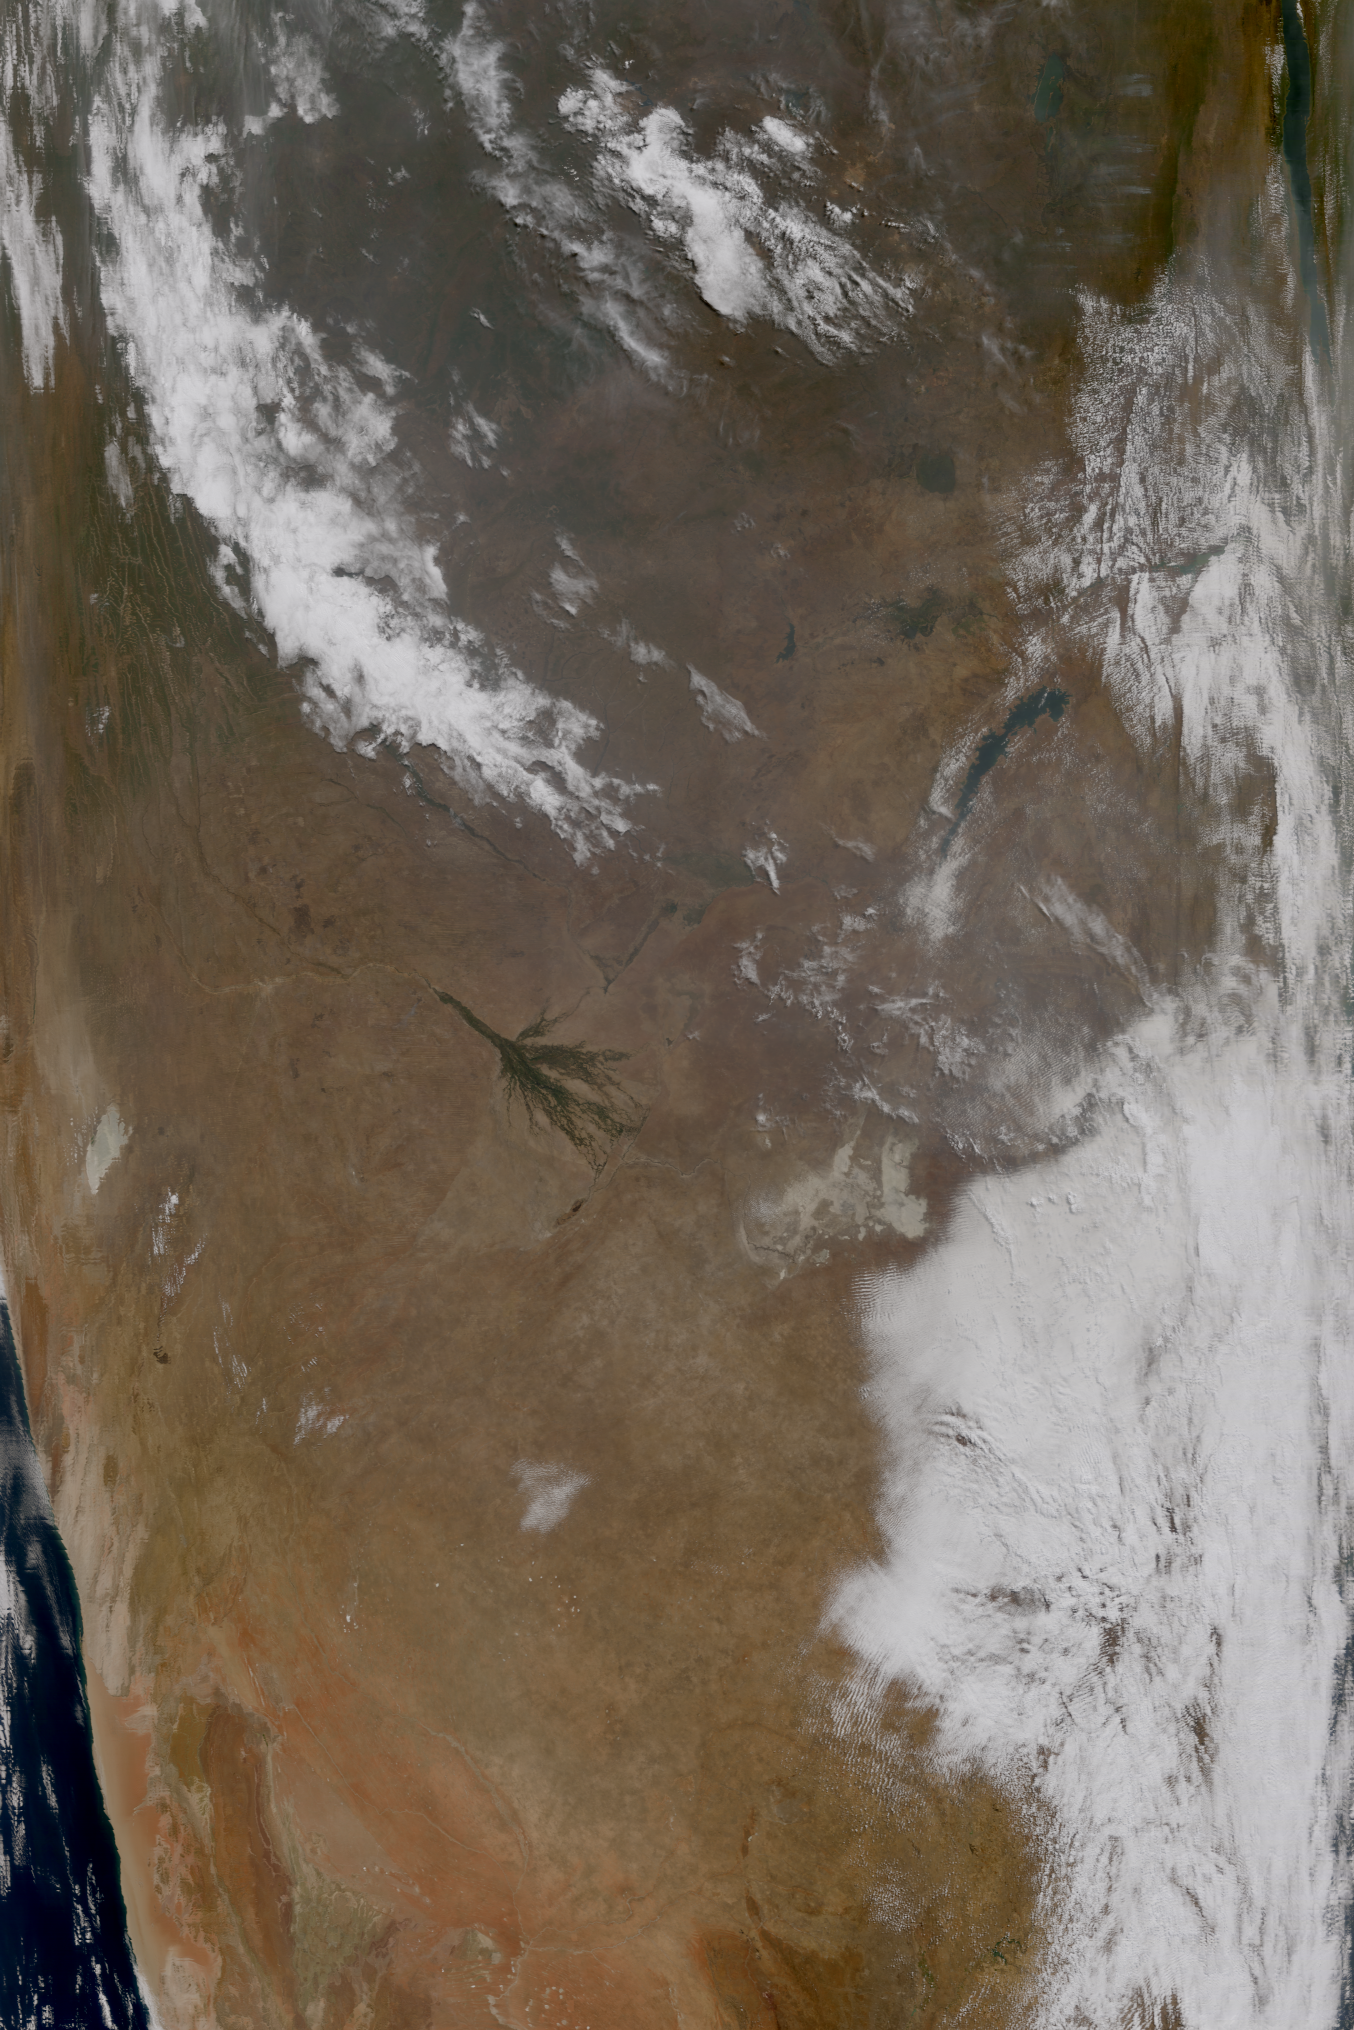

In [16]:
scn.load(['true_color', '20'], resolution=1000)
scn.show('true_color')

### Resample to a different projection

In the plot above you can see that the raw MODIS data has distortion towards edge of the image. By regridding the data we can avoid some of this distortion.

In [ ]:
area_id = "Southern Africa"
description = "Southern Africa in Mercator-Projection"
proj_id = "Southern Africa"
proj_dict = {"proj": "eqc"}

width = 1000    # width of the result domain in pixels
height = 1000   # height of the result domain in pixels

llx =  23E5   # projection x coordinate of lower left corner of lower left pixel
lly =  -22.9E5   # projection y coordinate of lower left corner of lower left pixel
urx =  48E5   # projection x coordinate of upper right corner of upper right pixel
ury =  -1.9E5   # projection y coordinate of upper right corner of upper right pixel

area_extent = (llx,lly,urx,ury)
from pyresample import create_area_def
resolution=1000
center =(0,0)
area_def = create_area_def(area_id, proj_dict, center=center, resolution=resolution)

modis_scn = scn.resample(area_def, radius_of_influence=10000)

In [ ]:
modis_scn.show('true_color')

## Load MODIS Fire Database

Now we're going to load the modis fire database from CSV files. This contains the longitude, latitude, and time of where fires have been detected to occur. It also includes an estimate of the Fire Radiative Power (FRP), a measure of the intensity of the fire, for each fire detected.

In [ ]:
fires = cat['modis_fires'].read()

time = fires.acq_date.astype(str) + ' ' + fires.acq_time.astype(str).str.zfill(4)
fires['timestamp'] = pd.to_datetime(time, format='%Y-%m-%d %H%M')
fires = fires.loc[fires.satellite == 'Terra']
fires = geopandas.GeoDataFrame(
    fires, geometry=geopandas.points_from_xy(fires.longitude, fires.latitude))

# We're only interested in data from Southern Africa for now
llx =  0    # projection x coordinate of lower left corner of lower left pixel
lly =  -30  # projection y coordinate of lower left corner of lower left pixel
urx =  55   # projection x coordinate of upper right corner of upper right pixel
ury =  10   # projection y coordinate of upper right corner of upper right pixel

fires = fires.cx[llx:urx, lly:ury]
fires.set_index('timestamp', drop=False, inplace=True)
fires = fires.sort_index()
fires = fires.loc['2020-09-01 00:00:00':'2020-10-01 00:00:00']
fires

### Daily Fire Radiative Power

Here we plot the Fire Radiative Power (FRP) for each day of the month of September. FRP is a measure of the intensity of a fire in units of MegaWatts.

In [ ]:
from bokeh.models.formatters import DatetimeTickFormatter

def plot_timeseries(data, y_variable):
    """Timeseries plot showing the mean fire radiative power at each day as well as the 5% and 95%"""

    def percentile(n):
        def percentile_(x):
            return np.percentile(x, n)
        percentile_.__name__ = 'percentile_%s' % n
        return percentile_

    formatter = DatetimeTickFormatter(months='%b')

    bounds = data.groupby([data.index.day_of_year])[y_variable].agg([percentile(5), percentile(95)])
    avg = data.groupby([data.index.day_of_year])[y_variable].mean()

    bounds.index = data.groupby([data.index.day_of_year])['timestamp'].first()
    avg.index = bounds.index

    tseries = hv.Overlay([
        (bounds.hvplot.area('timestamp', 'percentile_5', 'percentile_95',
                      alpha=0.2, color='red', xformatter=formatter)),
            avg.hvplot.line(x='timestamp', label=f'Average Daily FRP', color='red', xformatter=formatter)])

    return tseries.options(width=800, height=400, xlabel='Day',ylabel=f'FRP (MW)',legend_position='top_left')

plot_timeseries(fires, 'frp')

### Geographical distribution of Fires

Here we plot the geographical distribution of fires detected by MODIS over Southern Africa.

In [ ]:
fires.hvplot.points('longitude', 'latitude', groupby='index.day_of_year', c='frp', geo=True, alpha=0.2,
                    tiles='ESRI', xlim=(llx, urx), ylim=(lly, ury), cmap='autumn', logz=True,
                    dynamic=False)

## Visualising Fire Pixels with Satellite Imagery

Visualise a color image of the MODIS region using `hvplot`.

In [ ]:
modis_dataset = modis_scn.to_xarray_dataset()

img = get_enhanced_image(modis_scn['true_color'].squeeze())
img = img.data
img = img.clip(0, 1)
img = (img * 255).astype(np.uint8)

modis_dataset['true_color'] = img

grid = modis_scn.min_area().get_lonlats()
lons, lats = grid[0][0], grid[1][:, 0]
modis_dataset = modis_dataset.assign_coords(dict(x=lons, y=lats))
modis_dataset = modis_dataset.rename(dict(x='longitude', y='latitude'))

rgb = modis_dataset['true_color'].hvplot.rgb(x='longitude', y='latitude', bands='bands')
rgb

Get the fire pixels that are visible in the the MODIS scene by filtering the time, longitude & latitude. We can also compute which row and column the fire pixel is in for this projection.

In [ ]:
grid = modis_scn.min_area().get_lonlats()

# Mask any fire pixels not in this scene
time_mask = np.logical_and(fires.timestamp >= scn.attrs['start_time'],
                           fires.timestamp <= scn.attrs['end_time'])
fire_points = fires.loc[time_mask]
fire_points = fire_points.cx[grid[0].min():grid[0].max(), grid[1].min():grid[1].max()]

# extract the x and y coordinates as flat arrays
x = np.ravel(grid[0])
y = np.ravel(grid[1])
points = np.dstack([x, y]).squeeze()

# Find locations of fire pixels within satellite image
tree = cKDTree(points)
distance, idx = tree.query(fire_points[['longitude', 'latitude']], k=1)
index = np.unravel_index(idx, grid[0].shape)
index = np.vstack(index).T
index

# fire_points[['y', 'x']] = index
fire_points = fire_points[img.values[0, index[:, 0], index[:, 1]] != 0]
fire_points

Now overlay the fire pixels ontop of the MODIS image, along with the FRP for each fire pixel. Try zooming in, you should be able to see clear smoke trails at the locations of some of the fires!

In [ ]:
rgb = modis_dataset['true_color'].hvplot.rgb(x='longitude', y='latitude', bands='bands', data_aspect=1, hover=False, title='True Colour')
points = fire_points.hvplot.points('longitude', 'latitude', c='frp', cmap='autumn', logz=True, alpha=0.4)
rgb*points

We can also overlay the fire pixels ontop of the MODIS 3.7 micron wavelength band. The 3.7 band is a thermal band. Fires will appear as very bright pixels in image. Try zooming in, you should be able to clearly see bright spots at the location of each fire pixel.

In [ ]:
rgb = modis_dataset['20'].hvplot.image(x='longitude', y='latitude', cmap='viridis', data_aspect=1, hover=False, title='Band 20: 3.7 micron')
points = fire_points.hvplot.points('longitude', 'latitude', c='frp', cmap='autumn', logz=True, alpha=0.4)
rgb*points

## Summary

This notebook has demonstrated the use of:
 - The `satpy` package to easily load, plot and regrid satellite data from the MODIS sensor.
 - `hvplot` to interatively visualise wildfire pixels detected from the MODIS sensor.
 - `geopandas` to load, filter, and manipulate historical wildfire pixel data.